<a href="https://colab.research.google.com/github/dmachlanski/iads-summer-school-causality-2021/blob/main/labs/Exercise_IHDP_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference - Exercise (IHDP)

This is an opportunity for everyone to put into practice everything we have learnt so far. The data for this exercise comes from Infant Health Development Program study and was modified specifically for causal inference estimation purposes. More precisely, this dataset was formally introduced by [Hill (2011)](https://doi.org/10.1198/jcgs.2010.08162). It is a commonly used semi-simulated dataset in the CI community that combines pre-treatment covariates (X) and treatment assignments (T) from a real study, and simulated outcomes (Y). Because all outcomes are generated (both $y_1$ and $y_0$), we can measure individual as well as average treatment effect errors. For training purposes, only one of the outcomes is available to the estimator. The other is hidden and used only for evaluation purposes.

The experiment where the covariates come from measured various aspects of premature infants and their mothers, and how receiving specialised childcare affected the cognitive test score of the infants later on. The treatment groups are made imbalanced by removing a subset of the treated individuals. The variables are a mixture of contonuous and binary features. Treatment is binary. The outcome Y is continuous. Overall, we have 25 background features X. The data consists of 747 samples (139 treated, 608 control).

In terms of evaluation metrics, we are interested in predicting both individual and average treatment effects for this task. As the outcomes are simulated, we have access to both true outcomes $\mathcal{Y}_1$ and $\mathcal{Y}_0$ for each individual (i). As a result, we have access to true ITEs and true ATE:

$$ITE^{(i)} = \mathcal{Y}_1^{(i)} - \mathcal{Y}_0^{(i)}$$

$$ATE = \mathbb{E}[ITE]$$

We can define our predictions as:

$$\widehat{ITE}^{(i)} = \hat{y}_1^{(i)} - \hat{y}_0^{(i)}$$

$$\widehat{ATE} = \frac{1}{n}\sum \limits_{i=1}^{n}\widehat{ITE}^{(i)}$$

This allows us to define measurement errors with respect to each as:

$$\epsilon_{PEHE} = \sqrt{\frac{1}{n}\sum \limits_{i=1}^{n}(\widehat{ITE}^{(i)} - ITE^{(i)})^2}$$

$$\epsilon_{ATE} = \left| \widehat{ATE} - ATE \right|$$

Where PEHE stands for Precision in Estimation of Heterogeneous Effect, and which essentially is a Root Mean Squared Error (RMSE) between predicted and true ITEs. Implementations of both metrics are provided below.

In [1]:
def rmse(a, b):
    return np.sqrt(((a - b)**2).mean())

def ate_error(pred_te, true_te):
  return np.abs(np.mean(pred_te) - np.mean(true_te))

def pehe_error(pred_te, true_te):
  return rmse(true_te, pred_te)

We suggest the following steps:
1. Import packages.
    1. Remember to install EconML if you want to use it.
2. Data.
    1. Can be accessed at the following URLs:
        1. Training: https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/ihdp_train.npz
        2. Testing: https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/ihdp_test.npz
    2. Use 'wget' command to download them into the notebook (or upload manually).
    3. Explore the data (print a few samples, plot distributions - see plot_dist function below).
3. Data pre-processing.
    1. No data splitting required (train and test already provided).
    2. Scaling.
4. Train estimators of your choice (re-use already presented ones or explore different methods.
  1. EconML - [CATE estimators](https://econml.azurewebsites.net/reference.html#cate-estimators).
  2. scikit-learn - [supervised methods](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).
5. Make predictions.
6. Evaluate your models.
    1. Measure ATE and PEHE errors.

In [20]:
def _trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_dist(data, bins=10):
    """
    data: 2-dimensional numpy array
    bins: number of bins in the histograms
    """
    if data.shape[1] > 1:
        sq = math.sqrt(data.shape[1])
        d_ceil = math.ceil(sq)
        d_floor = math.floor(sq)

        if (d_ceil * d_floor) >= data.shape[1]:
            n_rows = d_floor
            n_cols = d_ceil
        else:
            n_rows = n_cols = d_ceil

        _, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
        axs = _trim_axs(axs, data.shape[1])

        for i, ax in enumerate(axs):
            ax.hist(data[:, i], bins=bins)
    else:
        plt.hist(data, bins=bins)
    
    plt.show()

In [3]:
!pip install econml

     |████████████████████████████████| 3.0 MB 8.9 MB/s 
     |████████████████████████████████| 352 kB 52.7 MB/s 
     |████████████████████████████████| 123 kB 62.9 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490520 sha256=3dd1ae94cd921da341cf97240ce294bbda5dd31634ba9752b4cb99df5fd8d9e3
  Stored in directory: /root/.cache/pip/wheels/34/33/98/2c03c2e06312e616f7a8dad3fbbcc78fc9eb1d665abcef1060
Successfully built shap
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [31]:
from econml.metalearners import XLearner
from econml.grf import CausalForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import math

In [5]:
!wget https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/ihdp_train.npz
!wget https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/ihdp_test.npz

--2021-07-29 14:27:34--  https://github.com/dmachlanski/iads-summer-school-causality-2021/raw/main/labs/data/ihdp_train.npz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2021/main/labs/data/ihdp_train.npz [following]
--2021-07-29 14:27:35--  https://raw.githubusercontent.com/dmachlanski/iads-summer-school-causality-2021/main/labs/data/ihdp_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151488 (148K) [application/octet-stream]
Saving to: ‘ihdp_train.npz’

ihdp_train.npz      100%[===================>] 147.94K  --.-KB/s    in 0.01s   

2021

In [6]:
data_train = np.load('ihdp_train.npz')
data_test = np.load('ihdp_test.npz')

In [7]:
data_train.files

['x', 't', 'y', 'te']

In [8]:
data_test.files

['x', 't', 'y', 'te']

In [11]:
x_train = data_train['x']
t_train = data_train['t']
y_train = data_train['y']
te_train = data_train['te']

In [23]:
x_test, t_test, y_test, te_test = data_test['x'], data_test['t'], data_test['y'], data_test['te']

In [22]:
for f in data_train.files:
  print(f'{f}: {data_train[f].shape}')

x: (672, 25)
t: (672, 1)
y: (672, 1)
te: (672, 1)


In [24]:
for f in data_test.files:
  print(f'{f}: {data_test[f].shape}')

x: (75, 25)
t: (75, 1)
y: (75, 1)
te: (75, 1)


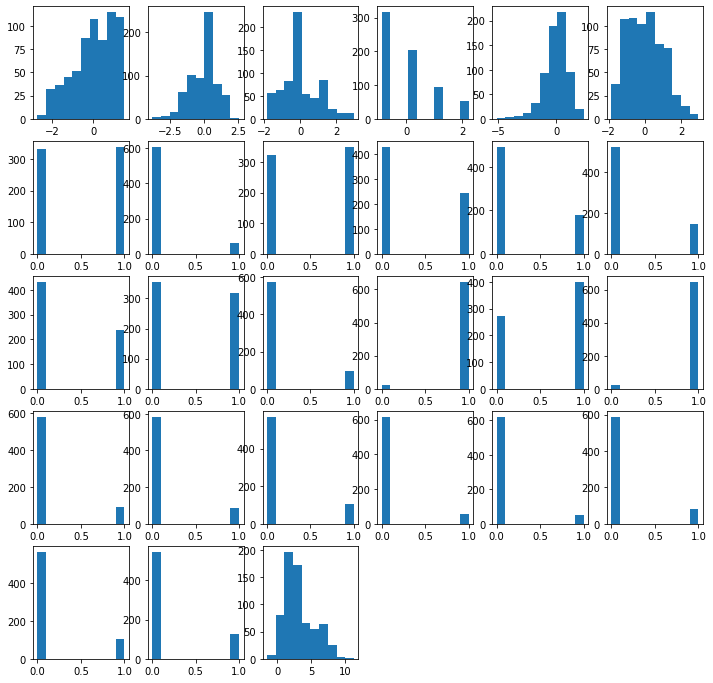

In [21]:
xty_train = np.concatenate([x_train, t_train, y_train], axis=1)

#np.vstack
#np.hstack

plot_dist(xty_train)

In [26]:
scaler_x = StandardScaler()

x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

In [35]:
lr = LinearRegression()

xt_train = np.concatenate([x_train, t_train], axis=1)
lr.fit(xt_train, y_train.flatten())

lr_y0 = lr.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
lr_y1 = lr.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

lr_te = lr_y1 - lr_y0

In [29]:
def get_ps_weights(clf, x, t):
  ti = np.squeeze(t)
  clf.fit(x, ti)
  
  # n_samples, n_classes
  #ps = clf.predict_proba(x)

  # n_classes, n_samples
  #ps_t = ps.T

  # 0
  # 1
  # 1, n_samples
  #ps_t1 = ps_t[1]

  # n_samples, 1
  #ps_t1.T
  
  ptx = clf.predict_proba(x).T[1].T + 0.0001
  return ti / ptx + ((1.0 - ti) / (1.0 - ptx))

In [36]:
lr_clf = LogisticRegression()
weights = get_ps_weights(lr_clf, x_train, t_train)

lr_ipw = LinearRegression()

xt_train = np.concatenate([x_train, t_train], axis=1)
lr_ipw.fit(xt_train, y_train.flatten(), sample_weight=weights)

lr_ipw_y0 = lr_ipw.predict(np.concatenate([x_test, np.zeros_like(t_test)], axis=1))
lr_ipw_y1 = lr_ipw.predict(np.concatenate([x_test, np.ones_like(t_test)], axis=1))

lr_ipw_te = lr_ipw_y1 - lr_ipw_y0

In [37]:
cf = CausalForest()

cf.fit(x_train, t_train, y_train)

cf_te = cf.predict(x_test)

In [ ]:
#def ate_error(pred_te, true_te):
#def pehe_error(pred_te, true_te):

In [38]:
lr_ate_e = ate_error(lr_te, te_test)
lr_pehe_e = pehe_error(lr_te, te_test)

lr_ipw_ate_e = ate_error(lr_ipw_te, te_test)
lr_ipw_pehe_e = pehe_error(lr_ipw_te, te_test)

cf_ate_e = ate_error(cf_te, te_test)
cf_pehe_e = pehe_error(cf_te, te_test)

In [40]:
results = []
results.append(['LR', lr_ate_e, lr_pehe_e])
results.append(['LR (IPW)', lr_ipw_ate_e, lr_ipw_pehe_e])
results.append(['CF', cf_ate_e, cf_pehe_e])

cols = ['Method', 'ATE', 'PEHE']

df = pd.DataFrame(results, columns=cols)
df

,Method,ATE,PEHE
0,LR,0.100136,0.966722
1,LR (IPW),0.063431,0.963612
2,CF,0.040810,0.420884
